In [1]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# === ETF list ===
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS', 'PSQ', 'VNQ', 'SPY', 'QQQ'
]

# === Date range ===
today = datetime.today()
start_date = (today - timedelta(weeks=52 * 8)).strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')
print(f"🗕️ Downloading weekly data from {start_date} to {end_date} (until last friday)")

# === Output folder ===
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
os.makedirs(dataset_path, exist_ok=True)

# === Containers ===
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# === Shift logic ===
def shift_to_next_friday(date):
    weekday = date.weekday()
    days_until_friday = (4 - weekday + 7) % 7
    return date + timedelta(days=days_until_friday)

# === Download each ETF ===
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(
        symbol,
        start=start_date,
        end=end_date,
        interval='1wk',
        auto_adjust=False,
        progress=False
    )
    if not data.empty:
        data = data[~data.index.duplicated(keep='first')].sort_index()
        data.index = data.index.to_series().apply(shift_to_next_friday)

        # ❌ Filter out future dates after shifting
        data = data[data.index <= pd.Timestamp(today.date())]

        # ✅ Store
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# === Merge and Save in clean format ===
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[df.index < pd.Timestamp(today.date())]  # 🚫 Final future filtering
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    df.insert(0, 'Date', df.index.strftime('%Y-%m-%d'))
    df.to_csv(os.path.join(dataset_path, filename), index=False)
    print(f"✅ Saved: {filename}")
    return df

# === Save all ===
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# === Preview ===
price_df.head()


🗕️ Downloading weekly data from 2017-05-06 to 2025-04-26 (until last friday)
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLRE...
⬇️ Downloading XLU...
⬇️ Downloading XLB...
⬇️ Downloading XLC...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading JETS...
⬇️ Downloading PSQ...
⬇️ Downloading VNQ...
⬇️ Downloading SPY...
⬇️ Downloading QQQ...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price,Date,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,...,SOXX,SH,DOG,RWM,ITA,JETS,PSQ,VNQ,SPY,QQQ
Ticker,,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,...,SOXX,SH,DOG,RWM,ITA,JETS,PSQ,VNQ,SPY,QQQ
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-12,2017-05-12,50.987156,20.209099,65.875282,47.737381,57.631672,82.852318,44.310497,23.967724,40.034260,...,43.491264,122.815491,62.593395,41.418320,70.177376,28.562231,171.764145,59.389893,209.603897,131.085373
2017-05-19,2017-05-19,50.693497,20.028975,65.656548,47.969902,57.509983,82.271561,44.624924,24.288721,40.305119,...,44.145664,123.176262,62.803650,41.888882,70.301323,28.552635,172.573349,60.054825,209.016266,130.366501
2017-05-26,2017-05-26,51.739666,20.251995,66.409111,46.934132,58.596561,83.645058,45.552094,24.456860,41.326679,...,45.171803,121.444450,61.997597,41.409611,72.330261,29.713936,168.484756,60.398254,211.998322,133.563263
2017-06-02,2017-06-02,52.482994,20.114750,67.747948,45.863121,59.291962,85.027771,46.172894,24.640287,42.007725,...,45.976730,120.217728,61.541992,40.686325,73.220772,30.069042,165.801605,60.990093,214.155945,135.681839
2017-06-09,2017-06-09,51.409290,20.835279,67.835472,46.800247,59.031178,83.303970,45.689152,24.594437,41.535629,...,45.439087,120.578522,61.331715,40.207050,72.550606,30.203407,169.847595,61.136230,213.489349,132.390488


In [2]:
import os 
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# === Macro indicator tickers ===
macro_tickers = {
    'VIX': '^VIX',
    '10Y_Yield': '^TNX',   # Scale * 0.1
    '2Y_Yield': '^IRX',    # Scale * 0.01
    'USD_Index': 'DX-Y.NYB',
    'WTI_Crude': 'CL=F',

}

# === Date range ===
today = datetime.today()
back_time = today - timedelta(weeks=52 * 10)
start_date = back_time.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

print(f"📊 Downloading macro indicators from {start_date} to {end_date}")

# === Output path ===
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))

# === Shift helper ===
def shift_to_next_friday(date):
    days_ahead = (4 - date.weekday() + 7) % 7
    return date + timedelta(days=days_ahead)

# === Download each macro ticker ===
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"⬇️ Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        data = data[~data.index.duplicated(keep='first')].sort_index()
        data.index = pd.to_datetime([shift_to_next_friday(d) for d in data.index])
        #filter futrue data
        data = data[data.index < pd.Timestamp(today.date())]
        macro_data[name] = data[['Close']].rename(columns={'Close': name})

# === Combine into single DataFrame ===
macro_df = pd.concat(macro_data.values(), axis=1)
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')].sort_index()

# === Apply scaling to yields ===
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] *= 0.1
if '2Y_Yield' in macro_df.columns:
    macro_df['2Y_Yield'] *= 0.01

# === Final cleanup ===
macro_df.dropna(axis=0, how='all', inplace=True)
macro_df.insert(0, 'Date', macro_df.index.strftime('%Y-%m-%d'))
macro_df.to_csv(macro_save_path, index=False)

print(f"✅ Macro indicators saved to: {macro_save_path}")


📊 Downloading macro indicators from 2015-05-09 to 2025-04-26
⬇️ Downloading VIX (^VIX)...
⬇️ Downloading 10Y_Yield (^TNX)...
⬇️ Downloading 2Y_Yield (^IRX)...
⬇️ Downloading USD_Index (DX-Y.NYB)...
⬇️ Downloading WTI_Crude (CL=F)...
✅ Macro indicators saved to: D:\CodingWorks\Weekly_Swing_TransformerQT\dataset\macro_indicators_weekly.csv


In [3]:
# calculate TA signals


import os
import pandas as pd
from ta import momentum, trend, volume

# === Paths ===
price_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_prices_weekly.csv'))
volume_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_volume_weekly.csv'))

# === Helper to load ETF CSVs ===
def load_etf_csv(path, name='[unknown]'):
    try:
        header_row = pd.read_csv(path, header=None, nrows=2)
        columns = header_row.iloc[1].tolist()[1:]
        df = pd.read_csv(path, skiprows=3, header=None)
        df = df.iloc[:, :len(columns) + 1]
        df.columns = ['Date'] + columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')
        df = df.apply(pd.to_numeric, errors='coerce')
        print(f"✅ Loaded {name} with {len(columns)} tickers")
        return df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        raise

# === Load data ===
price_df = load_etf_csv(price_path, name='ETF Prices')
volume_df = load_etf_csv(volume_path, name='ETF Volume')

# === Feature storage ===
features_all = []
skipped = []

# === Feature generation loop ===
for symbol in price_df.columns:
    if symbol not in volume_df.columns:
        print(f"⚠️ Skipping {symbol}: volume data missing.")
        skipped.append(symbol)
        continue

    df = pd.DataFrame(index=price_df.index)
    df['close'] = price_df[symbol]
    df['volume'] = volume_df[symbol]

    try:
        # === Return-based technical indicators ===
        df[f'{symbol}_ret_1w'] = df['close'].pct_change(1)
        df[f'{symbol}_ret_3w'] = df['close'].pct_change(3)
        df[f'{symbol}_ret_6w'] = df['close'].pct_change(6)

        high = df['close'].rolling(window=14).max()
        low = df['close'].rolling(window=14).min()
        df[f'{symbol}_stoch_k'] = 100 * (df['close'] - low) / (high - low)
        df[f'{symbol}_stoch_d'] = df[f'{symbol}_stoch_k'].rolling(window=3).mean()
        df[f'{symbol}_williams_r'] = -100 * (high - df['close']) / (high - low)

        df[f'{symbol}_cci'] = trend.cci(high=df['close'], low=df['close'], close=df['close'], window=20)
        df[f'{symbol}_rsi'] = momentum.rsi(df['close'], window=14)
        df[f'{symbol}_obv'] = volume.on_balance_volume(df['close'], df['volume'])

        df[f'{symbol}_macd'] = trend.macd(df['close'])
        df[f'{symbol}_macd_signal'] = trend.macd_signal(df['close'])
        df[f'{symbol}_macd_diff'] = trend.macd_diff(df['close'])

        # === Short-term KST (custom) ===
        roc1 = df['close'].pct_change(10)
        roc2 = df['close'].pct_change(15)
        roc3 = df['close'].pct_change(20)
        roc4 = df['close'].pct_change(30)
        df[f'{symbol}_kst_short'] = (
            roc1.rolling(10).mean() +
            roc2.rolling(10).mean() * 2 +
            roc3.rolling(10).mean() * 3 +
            roc4.rolling(15).mean() * 4
        )

        derived_cols = df.columns.difference(['close', 'volume'])
        feature_df = df[derived_cols].copy()

        features_all.append(feature_df)
        print(f"📈 {symbol}: {feature_df.dropna(how='all').shape[0]} valid rows")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        skipped.append(symbol)

# === Final merge ===
if len(features_all) == 0:
    raise ValueError("🛑 No valid ETF features generated.")

features_df = pd.concat(features_all, axis=1).sort_index()
features_df = features_df[~features_df.index.duplicated(keep='first')]

print("📀 Final feature shape:", features_df.shape)

# === Save to CSV ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
features_df.to_csv(os.path.join(base_dir, 'weekly_etf_tech_feature.csv'))
print(f"✅ Saved features to: weekly_etf_tech_feature.csv")


✅ Loaded ETF Prices with 21 tickers
✅ Loaded ETF Volume with 21 tickers
📈 XLK: 415 valid rows
📈 XLF: 415 valid rows
📈 XLV: 415 valid rows
📈 XLE: 415 valid rows
📈 XLI: 415 valid rows
📈 XLY: 415 valid rows
📈 XLP: 415 valid rows
📈 XLRE: 415 valid rows
📈 XLU: 415 valid rows
📈 XLB: 415 valid rows
📈 XLC: 402 valid rows
📈 SOXX: 415 valid rows
📈 SH: 415 valid rows
📈 DOG: 415 valid rows
📈 RWM: 415 valid rows
📈 ITA: 415 valid rows
📈 JETS: 415 valid rows
📈 PSQ: 415 valid rows
📈 VNQ: 415 valid rows
📈 SPY: 415 valid rows
📈 QQQ: 415 valid rows
📀 Final feature shape: (415, 273)
✅ Saved features to: weekly_etf_tech_feature.csv


In [4]:
# normalizing matrix add masks


# Normalize and mask using consistent CSV structure
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
feat_path = os.path.join(base_dir, 'weekly_etf_tech_feature.csv')
macro_path = os.path.join(base_dir, 'macro_indicators_weekly.csv')
price_path = os.path.join(base_dir, 'etf_prices_weekly.csv')

# === Load Data ===
feat_df = pd.read_csv(feat_path)
macro_df = pd.read_csv(macro_path)
price_df = pd.read_csv(price_path)

# === Set Index ===
feat_df.set_index('Date', inplace=True)
macro_df.set_index('Date', inplace=True)
price_df.set_index('Date', inplace=True)

# === Convert index to datetime
today = pd.Timestamp.today().normalize()
feat_df.index = pd.to_datetime(feat_df.index)
macro_df.index = pd.to_datetime(macro_df.index)
price_df.index = pd.to_datetime(price_df.index)

feat_df = feat_df[feat_df.index < today]
macro_df = macro_df[macro_df.index < today]
price_df = price_df[price_df.index < today]

# === Drop duplicated rows if any
feat_df = feat_df[~feat_df.index.duplicated()]
macro_df = macro_df[~macro_df.index.duplicated()]
price_df = price_df[~price_df.index.duplicated()]

# === Output Directory ===
norm_dir = os.path.join(base_dir, 'normalized_matrix')
os.makedirs(norm_dir, exist_ok=True)

# === Scaler
scaler = StandardScaler()

# === Detect unique tickers
all_cols = feat_df.columns
tickers = sorted(set(col.split('_')[0] for col in all_cols if '_' in col))
print(f"🧾 Tickers detected: {tickers}")

for ticker in tickers:
    feat_cols = [c for c in feat_df.columns if c.startswith(f"{ticker}_")]
    if ticker not in price_df.columns:
        print(f"⚠️ Skipped {ticker}: no matching price data.")
        continue

    # Build DataFrame with date index
    df = pd.DataFrame(index=feat_df.index)

    # Add technical indicators
    for col in feat_cols:
        clean_name = col.replace(f"{ticker}_", "")
        df[clean_name] = feat_df[col]

    # Add price
    df.insert(0, 'price', price_df[ticker])

    # Add macro indicators
    df = df.join(macro_df, how='left')

    # Create mask before filling NAs
    mask = df.isna().astype(float)


    # Normalize technical (non-macro) features
    macro_cols = macro_df.columns
    norm_cols = df.columns.difference(macro_cols.union({'price'}))

    if df[norm_cols].dropna(how='all').empty:
        print(f"⚠️ Skipped {ticker}: no valid technical features.")
        continue

    df[norm_cols] = scaler.fit_transform(df[norm_cols].fillna(0.0))
    df[macro_cols] = df[macro_cols].fillna(0.0)

    # === Save
    df.to_csv(os.path.join(norm_dir, f'{ticker}_combined.csv'))
    mask.to_csv(os.path.join(norm_dir, f'{ticker}_mask.csv'))
    print(f"✅ Saved {ticker}: {df.shape[0]} rows, {df.shape[1]} features")


🧾 Tickers detected: ['DOG', 'ITA', 'JETS', 'PSQ', 'QQQ', 'RWM', 'SH', 'SOXX', 'SPY', 'VNQ', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
✅ Saved DOG: 415 rows, 19 features
✅ Saved ITA: 415 rows, 19 features
✅ Saved JETS: 415 rows, 19 features
✅ Saved PSQ: 415 rows, 19 features
✅ Saved QQQ: 415 rows, 19 features
✅ Saved RWM: 415 rows, 19 features
✅ Saved SH: 415 rows, 19 features
✅ Saved SOXX: 415 rows, 19 features
✅ Saved SPY: 415 rows, 19 features
✅ Saved VNQ: 415 rows, 19 features
✅ Saved XLB: 415 rows, 19 features
✅ Saved XLC: 415 rows, 19 features
✅ Saved XLE: 415 rows, 19 features
✅ Saved XLF: 415 rows, 19 features
✅ Saved XLI: 415 rows, 19 features
✅ Saved XLK: 415 rows, 19 features
✅ Saved XLP: 415 rows, 19 features
✅ Saved XLRE: 415 rows, 19 features
✅ Saved XLU: 415 rows, 19 features
✅ Saved XLV: 415 rows, 19 features
✅ Saved XLY: 415 rows, 19 features


# start training

In [5]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))

# === Dataset Class ===
class ETFDataset(Dataset):
    def __init__(self, combined_csv, mask_csv, etf, return_feature="ret_1w", seq_len=8):
        df = pd.read_csv(combined_csv, index_col=0)
        mask = pd.read_csv(mask_csv, index_col=0)
        self.seq_len = seq_len

        if 'price' not in df.columns:
            raise ValueError("'price' column is required for target computation.")

        if return_feature not in df.columns:
            raise ValueError(f"❌ Target column {return_feature} not found.")

        self.target_index = df.columns.get_loc(return_feature)
        self.raw_X = df.drop(columns=['price']).values.astype(np.float32)
        self.raw_M = mask.drop(columns=['price']).values.astype(np.float32)
        self.raw_price = df['price'].values.astype(np.float32)

        self.X, self.M, self.y = [], [], []

        for i in range(seq_len, len(self.raw_X) - 1):
            self.X.append(self.raw_X[i-seq_len:i])
            self.M.append(self.raw_M[i-seq_len:i])
            p_t_minus1 = self.raw_price[i-1]
            p_t = self.raw_price[i]
            self.y.append((p_t - p_t_minus1) / p_t_minus1 * 100)

        self.X = np.stack(self.X)
        self.M = np.stack(self.M)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx]),
            torch.tensor(self.M[idx]),
            torch.tensor(self.y[idx])
        )


# === Model Class ===
class CausalSelfAttentionBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        B, T, C = src.size()
        mask = torch.triu(torch.ones(T, T, device=src.device), diagonal=1).bool()
        attn_output, _ = self.attn(src, src, src, attn_mask=mask)
        src2 = self.norm1(src + attn_output)
        src2_ff = self.linear2(self.dropout(torch.relu(self.linear1(src2))))
        return self.norm2(src2 + src2_ff)


class DualTransformerModel(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, seq_len=8):
        super().__init__()
        nhead = max([h for h in [8, 4, 2, 1] if num_features % h == 0])
        self.encoder = nn.Sequential(
            *[CausalSelfAttentionBlock(num_features, nhead, hidden_dim) for _ in range(num_layers)]
        )
        self.time_weights = nn.Parameter(torch.randn(seq_len))
        self.output = nn.Linear(num_features, 1)

    def forward(self, x, mask):
        x_masked = x * (1 - mask)
        enc = self.encoder(x_masked)
        attn_weights = torch.softmax(self.time_weights, dim=0)
        pooled = torch.sum(enc * attn_weights.view(1, -1, 1), dim=1)
        return self.output(pooled).squeeze(-1)


# === Training Settings ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
max_epochs = 1000
seq_len = 8

# === Training Function ===
def train_one_etf(etf):
    print(f"\n🚀 Training {etf}")
    feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
    mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
    dataset = ETFDataset(feat_path, mask_path, etf=etf, return_feature="ret_1w", seq_len=seq_len)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    X, _, _ = next(iter(loader))
    model = DualTransformerModel(num_features=X.shape[-1], seq_len=seq_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    best_models = []

    for epoch in range(max_epochs):
        model.train()
        total_loss, win_count, total_count = 0, 0, 0
        all_preds, all_targets = [], []

        for X, M, y in loader:
            X, M, y = X.to(device), M.to(device), y.to(device)
            pred = model(X, M)

            loss = mse_loss(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            win_count += (torch.sign(pred) == torch.sign(y)).sum().item()
            total_count += len(y)
            all_preds.append(pred.detach().cpu().numpy())
            all_targets.append(y.detach().cpu().numpy())

        avg_loss = total_loss / len(loader)
        avg_win = win_count / total_count
        all_preds_np = np.concatenate(all_preds)
        all_targets_np = np.concatenate(all_targets)
        mae = np.mean(np.abs(all_preds_np - all_targets_np))

        score = avg_win * 0.6 + (1 - mae) * 0.4
        best_models.append((score, model.state_dict(), avg_win, mae))

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, MAE={mae:.4f}, WinRate={avg_win:.4f}")

    top5 = sorted(best_models, key=lambda x: -x[0])[:5]
    weight_sum = sum(x[0] for x in top5)

    save_dir = os.path.join("..", "model_weights")
    os.makedirs(save_dir, exist_ok=True)

    for i, (score, weights, win, mae) in enumerate(top5):
        torch.save({
            'weights': weights,
            'score': score,
            'win_rate': win,
            'mae': mae,
            'weight': score / weight_sum
        }, os.path.join(save_dir, f"{etf}_top{i+1}.pt"))

# === Start Training ===
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]
for etf in etf_list:
    train_one_etf(etf)



🚀 Training DOG
Epoch 100: Loss=6.0906, MAE=1.6866, WinRate=0.5345
Epoch 200: Loss=4.2874, MAE=1.4676, WinRate=0.6379
Epoch 300: Loss=3.0323, MAE=1.2451, WinRate=0.6773
Epoch 400: Loss=2.7253, MAE=1.2020, WinRate=0.7094
Epoch 500: Loss=1.6413, MAE=0.9434, WinRate=0.7808
Epoch 600: Loss=1.1136, MAE=0.8224, WinRate=0.7931
Epoch 700: Loss=1.3872, MAE=0.9065, WinRate=0.7783
Epoch 800: Loss=0.7551, MAE=0.6651, WinRate=0.8325
Epoch 900: Loss=0.5551, MAE=0.5755, WinRate=0.8547
Epoch 1000: Loss=1.4927, MAE=0.9293, WinRate=0.7660

🚀 Training ITA
Epoch 100: Loss=11.2011, MAE=2.2010, WinRate=0.6158
Epoch 200: Loss=9.3202, MAE=2.0121, WinRate=0.6626
Epoch 300: Loss=9.8794, MAE=2.1020, WinRate=0.6502
Epoch 400: Loss=5.1472, MAE=1.6237, WinRate=0.7192
Epoch 500: Loss=6.8145, MAE=1.9278, WinRate=0.6700
Epoch 600: Loss=3.0065, MAE=1.2838, WinRate=0.7882
Epoch 700: Loss=3.0515, MAE=1.3626, WinRate=0.7365
Epoch 800: Loss=1.7880, MAE=1.0575, WinRate=0.8399
Epoch 900: Loss=1.6883, MAE=0.9980, WinRate=0.83

In [6]:
# saving predition (with win/loss and return info)



import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
output_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === ETF list ===
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]

print("📊 Generating predictions:")
for etf in tqdm(etf_list):
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        mask_path = os.path.join(data_dir, f"{etf}_mask.csv")
        model_paths = [os.path.join(model_dir, f"{etf}_top{i+1}.pt") for i in range(3)]

        df_feat = pd.read_csv(feat_path, index_col=0)
        df_feat.index = pd.to_datetime(df_feat.index)
        df_feat = df_feat.astype('float32')

        df_mask = pd.read_csv(mask_path, index_col=0)
        df_mask.index = pd.to_datetime(df_mask.index)
        df_mask = df_mask.astype('float32')

        if 'price' not in df_feat.columns:
            print(f"⛔ {etf} skipped: 'price' column missing.")
            continue

        X_seq, M_seq, actual_prices, predicted_prices = [], [], [], []
        target_dates, input_dates = [], []

        seq_len = 8
        for i in range(seq_len, len(df_feat) - 1):
            X_seq.append(df_feat.iloc[i-seq_len:i].drop(columns='price').values)
            M_seq.append(df_mask.iloc[i-seq_len:i].drop(columns='price').values)
            actual_prices.append(df_feat.iloc[i+1]['price'])
            predicted_prices.append(None)
            target_dates.append(df_feat.index[i+1])
            input_dates.append(";".join(date.strftime('%Y-%m-%d') for date in df_feat.index[i-seq_len:i]))

        X_tensor = torch.tensor(np.array(X_seq), dtype=torch.float32).to(device)
        M_tensor = torch.tensor(np.array(M_seq), dtype=torch.float32).to(device)

        model = DualTransformerModel(num_features=X_tensor.shape[-1], seq_len=seq_len).to(device)
        weights = torch.zeros_like(model.state_dict()['encoder.layers.0.linear1.weight'])

        valid_weights = 0
        for model_path in model_paths:
            if os.path.exists(model_path):
                state_dict = torch.load(model_path, map_location=device)['weights']
                for k in model.state_dict().keys():
                    model.state_dict()[k].copy_(model.state_dict()[k] + state_dict[k])
                valid_weights += 1

        if valid_weights > 0:
            for k in model.state_dict().keys():
                model.state_dict()[k].div_(valid_weights)

        model.eval()

        with torch.no_grad():
            preds = model(X_tensor, M_tensor).cpu().numpy()

        pred_returns, actual_returns, win_flags = [], [], []

        for i, p in enumerate(preds):
            prev_price = df_feat.iloc[i + seq_len - 1]['price']
            actual_price = actual_prices[i]
            predicted_price = prev_price * (1 + p / 100)
            predicted_prices[i] = predicted_price

            actual_ret = (actual_price - prev_price) / prev_price * 100 if not np.isnan(actual_price) else None
            predicted_ret = p
            win_flag = int(np.sign(predicted_ret) == np.sign(actual_ret)) if actual_ret is not None else None

            pred_returns.append(predicted_ret)
            actual_returns.append(actual_ret)
            win_flags.append(win_flag)

        # === Future Prediction ===
        last_seq_X = df_feat.iloc[-seq_len:].drop(columns='price').values
        last_seq_M = df_mask.iloc[-seq_len:].drop(columns='price').values
        last_input_dates = df_feat.index[-seq_len:]
        last_prev_price = df_feat.iloc[-1]['price']
        last_target_date = df_feat.index[-1] + timedelta(days=7)

        with torch.no_grad():
            future_pred = model(
                torch.tensor([last_seq_X], dtype=torch.float32).to(device),
                torch.tensor([last_seq_M], dtype=torch.float32).to(device)
            ).item()
            future_price = last_prev_price * (1 + future_pred / 100)

        target_dates.append(last_target_date)
        input_dates.append(";".join(date.strftime('%Y-%m-%d') for date in last_input_dates))
        actual_prices.append('X')
        predicted_prices.append(future_price)
        pred_returns.append(future_pred)
        actual_returns.append(None)
        win_flags.append(None)

        df_result = pd.DataFrame({
            'Date': target_dates,
            'Input_Dates': input_dates,
            'Actual_Price': actual_prices,
            'Predicted_Price': predicted_prices,
            'Actual_Return(%)': actual_returns,
            'Predicted_Return(%)': pred_returns,
            'Win': win_flags
        }).set_index('Date')

        df_result.to_csv(os.path.join(output_dir, f"{etf}_pred_result.csv"))

    except Exception as e:
        print(f"⚠️ Failed on {etf}: {e}")


📊 Generating predictions:


  5%|███████████▌                                                                                                                                                                                                                                      | 1/21 [00:00<00:03,  6.48it/s]

⚠️ Failed on DOG: 'encoder.layers.0.linear1.weight'


 10%|███████████████████████                                                                                                                                                                                                                           | 2/21 [00:00<00:02,  6.56it/s]

⚠️ Failed on ITA: 'encoder.layers.0.linear1.weight'


 14%|██████████████████████████████████▌                                                                                                                                                                                                               | 3/21 [00:00<00:02,  6.52it/s]

⚠️ Failed on JETS: 'encoder.layers.0.linear1.weight'


 19%|██████████████████████████████████████████████                                                                                                                                                                                                    | 4/21 [00:00<00:02,  6.59it/s]

⚠️ Failed on PSQ: 'encoder.layers.0.linear1.weight'


 24%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                        | 5/21 [00:00<00:02,  6.47it/s]

⚠️ Failed on QQQ: 'encoder.layers.0.linear1.weight'


 29%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 6/21 [00:00<00:02,  6.43it/s]

⚠️ Failed on RWM: 'encoder.layers.0.linear1.weight'


 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 7/21 [00:01<00:02,  6.54it/s]

⚠️ Failed on SH: 'encoder.layers.0.linear1.weight'


 38%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 8/21 [00:01<00:01,  6.60it/s]

⚠️ Failed on SOXX: 'encoder.layers.0.linear1.weight'


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 9/21 [00:01<00:01,  6.58it/s]

⚠️ Failed on SPY: 'encoder.layers.0.linear1.weight'


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 10/21 [00:01<00:01,  6.59it/s]

⚠️ Failed on VNQ: 'encoder.layers.0.linear1.weight'


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 11/21 [00:01<00:01,  6.61it/s]

⚠️ Failed on XLB: 'encoder.layers.0.linear1.weight'


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 12/21 [00:01<00:01,  6.56it/s]

⚠️ Failed on XLC: 'encoder.layers.0.linear1.weight'


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 13/21 [00:01<00:01,  6.55it/s]

⚠️ Failed on XLE: 'encoder.layers.0.linear1.weight'


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 14/21 [00:02<00:01,  6.61it/s]

⚠️ Failed on XLF: 'encoder.layers.0.linear1.weight'


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 15/21 [00:02<00:00,  6.56it/s]

⚠️ Failed on XLI: 'encoder.layers.0.linear1.weight'


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 16/21 [00:02<00:00,  6.55it/s]

⚠️ Failed on XLK: 'encoder.layers.0.linear1.weight'


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 17/21 [00:02<00:00,  6.46it/s]

⚠️ Failed on XLP: 'encoder.layers.0.linear1.weight'


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 18/21 [00:02<00:00,  6.48it/s]

⚠️ Failed on XLRE: 'encoder.layers.0.linear1.weight'


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 19/21 [00:02<00:00,  6.53it/s]

⚠️ Failed on XLU: 'encoder.layers.0.linear1.weight'


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 20/21 [00:03<00:00,  6.53it/s]

⚠️ Failed on XLV: 'encoder.layers.0.linear1.weight'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  6.53it/s]

⚠️ Failed on XLY: 'encoder.layers.0.linear1.weight'


⚠️ Failed to load XLC: Axis limits cannot be NaN or Inf


C:\Users\user\AppData\Local\Temp\ipykernel_15076\1228295096.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


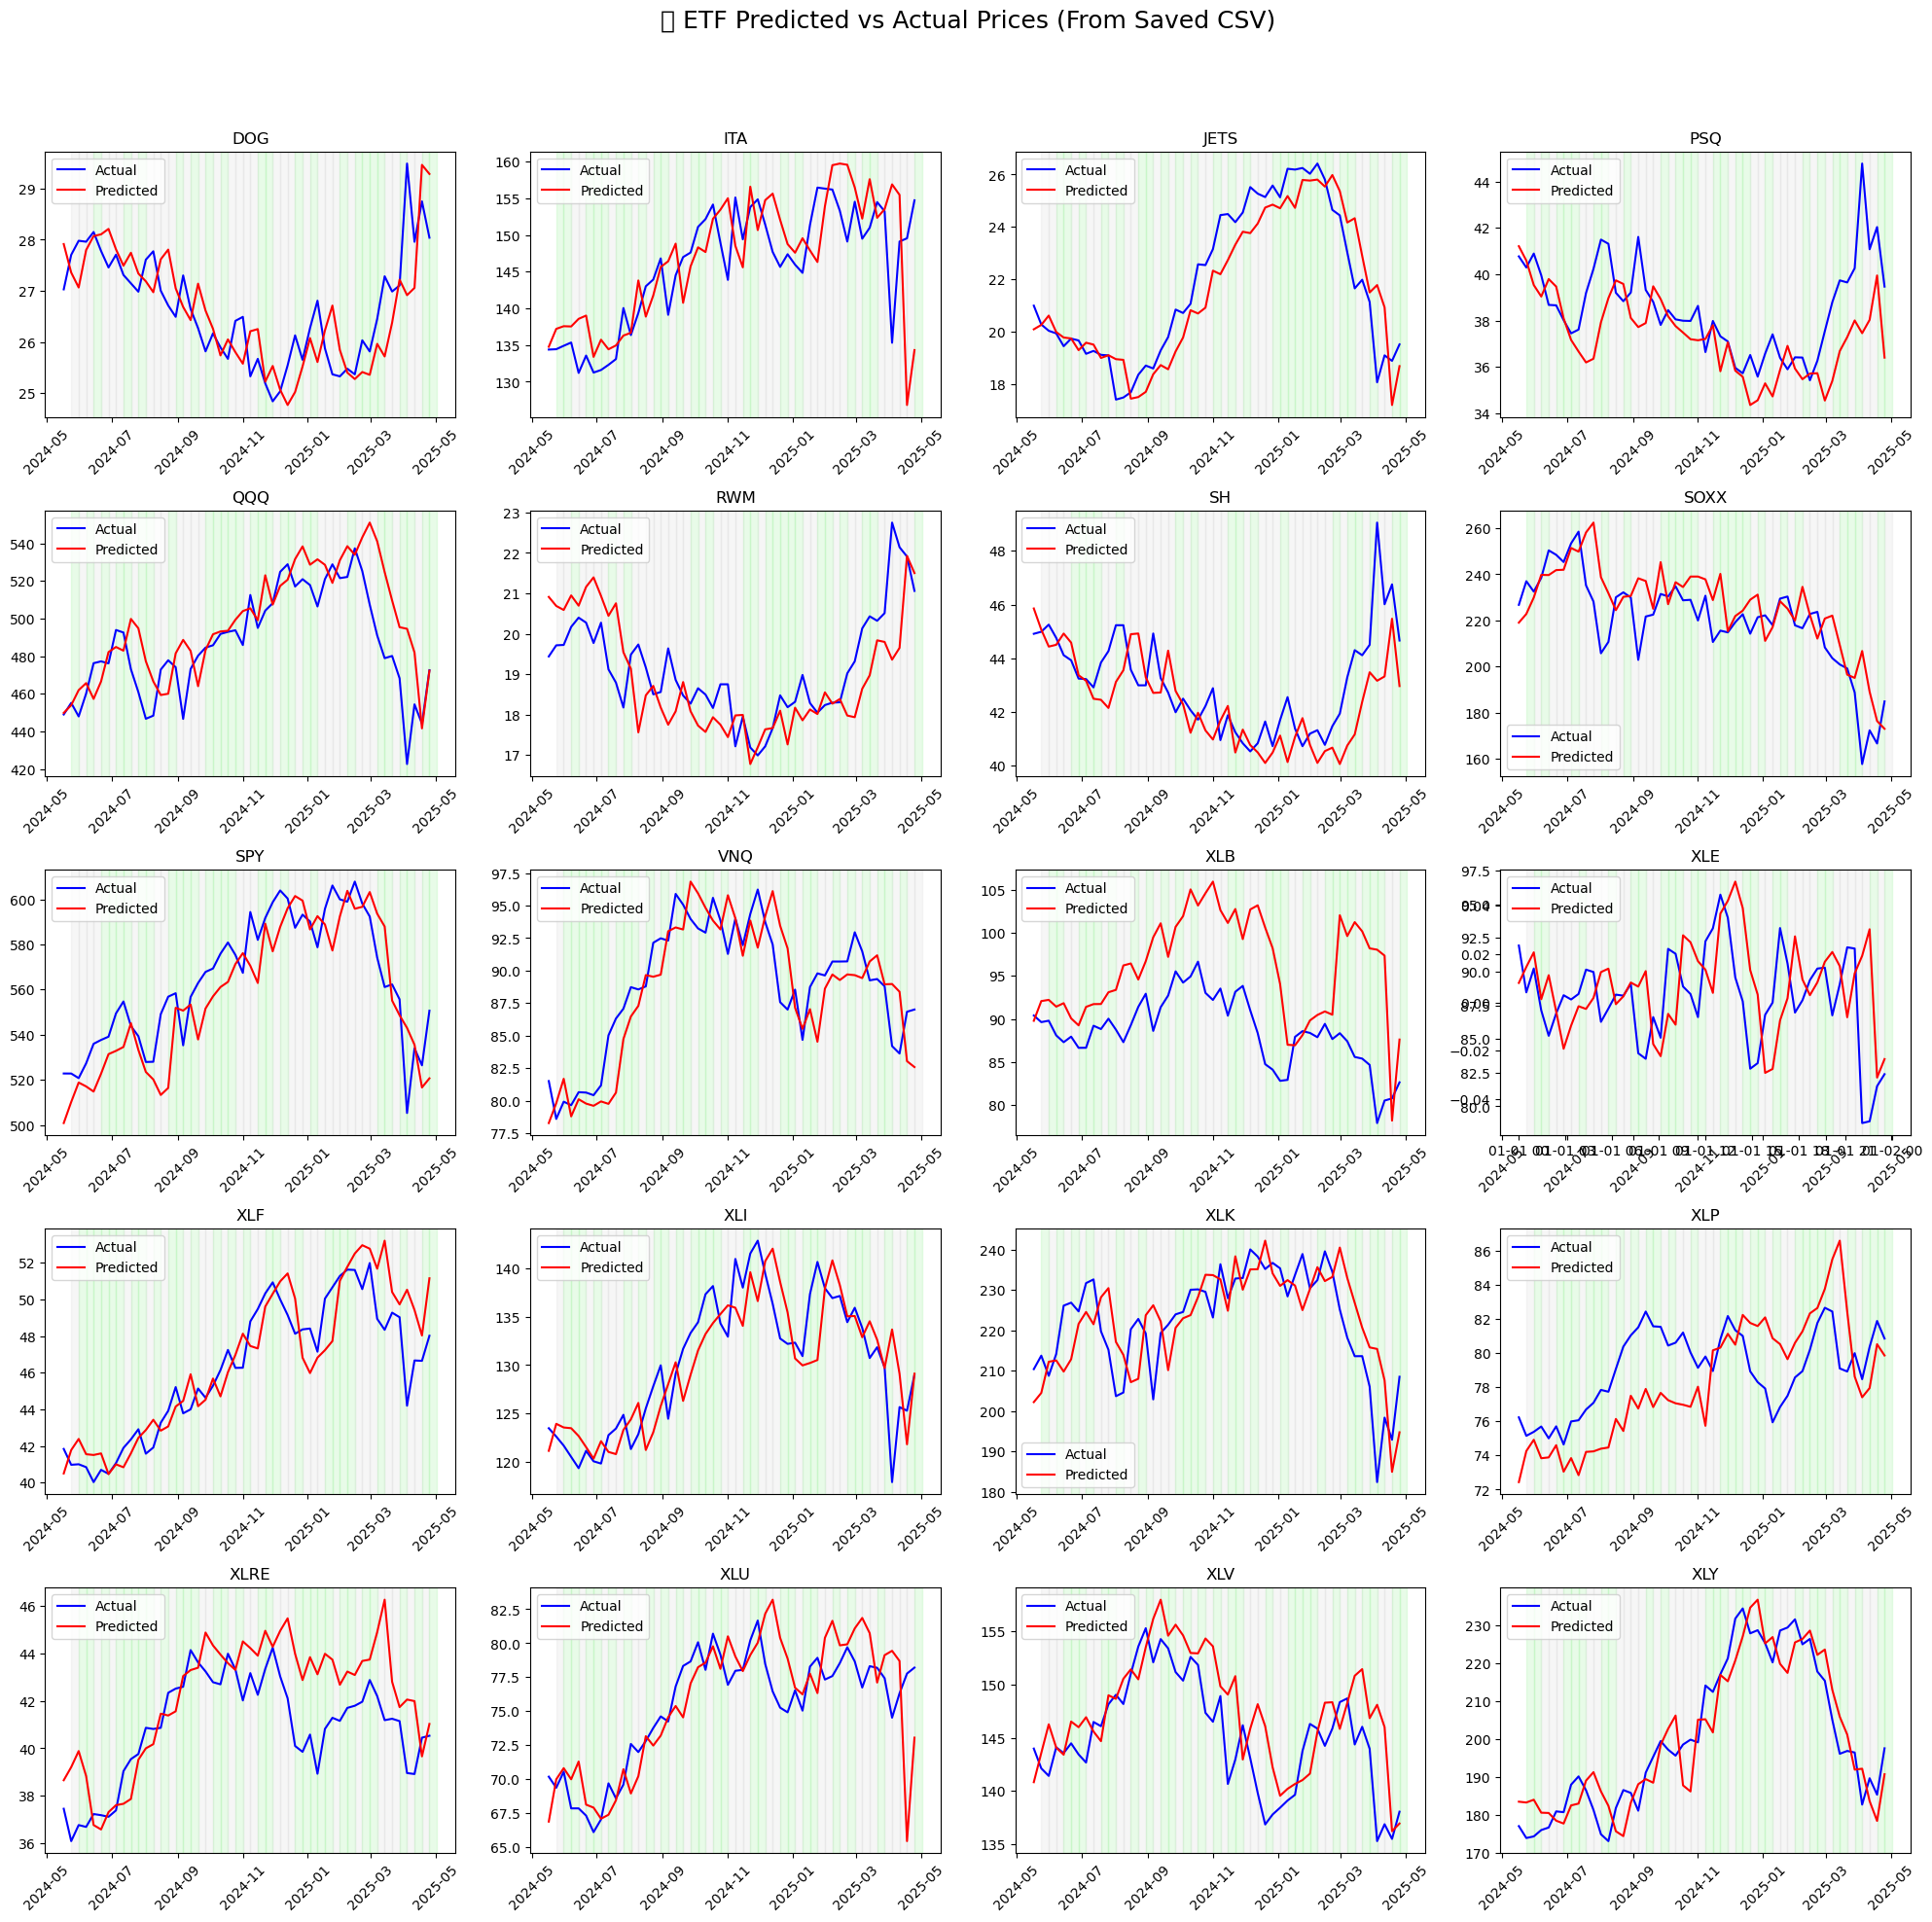

In [12]:
# plot showing cell

import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta

# === Paths ===
pred_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))

# === Get all prediction result files
result_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('_pred_result.csv')])
etf_list = [f.replace('_pred_result.csv', '') for f in result_files]

# === Plot
fig = plt.figure(figsize=(20, 4 * ((len(etf_list) + 3) // 4)))
gs = gridspec.GridSpec((len(etf_list) + 3) // 4, 4, figure=fig)

plot_idx = 0
for etf in etf_list:
    try:
        file_path = os.path.join(pred_dir, f"{etf}_pred_result.csv")

        # 🔍 Read the CSV properly
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df['Actual_Price'] = pd.to_numeric(df['Actual_Price'], errors='coerce')
        df['Predicted_Price'] = pd.to_numeric(df['Predicted_Price'], errors='coerce')
        df = df.dropna(subset=['Date', 'Actual_Price', 'Predicted_Price'])
        df.set_index('Date', inplace=True)

        # Use last 50 points
        df_show = df.iloc[-50:]

        ax = fig.add_subplot(gs[plot_idx])
        ax.plot(df_show.index, df_show['Actual_Price'], label='Actual', color='blue')
        ax.plot(df_show.index, df_show['Predicted_Price'], label='Predicted', color='red')

        # Set Y-axis margins (only over numeric columns)
        min_y = min(df_show['Actual_Price'].min(), df_show['Predicted_Price'].min())
        max_y = max(df_show['Actual_Price'].max(), df_show['Predicted_Price'].max())
        margin = (max_y - min_y) * 0.05
        ax.set_ylim(min_y - margin, max_y + margin)

        ax.set_title(etf)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)

        # Add background shading (green = correct trend direction, grey = wrong)
        for j in range(1, len(df_show)):
            pred_diff = df_show['Predicted_Price'].iloc[j] - df_show['Predicted_Price'].iloc[j-1]
            actual_diff = df_show['Actual_Price'].iloc[j] - df_show['Actual_Price'].iloc[j-1]
            color = 'lightgreen' if (pred_diff * actual_diff) > 0 else 'lightgrey'
            ax.axvspan(df_show.index[j], df_show.index[j] + timedelta(days=7), color=color, alpha=0.2)

        plot_idx += 1

    except Exception as e:
        print(f"⚠️ Failed to load {etf}: {e}")
        continue

# === Final Layout
fig.suptitle("📊 ETF Predicted vs Actual Prices (From Saved CSV)", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


⚠️ Error processing XLC: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


C:\Users\user\AppData\Local\Temp\ipykernel_15076\2269544582.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


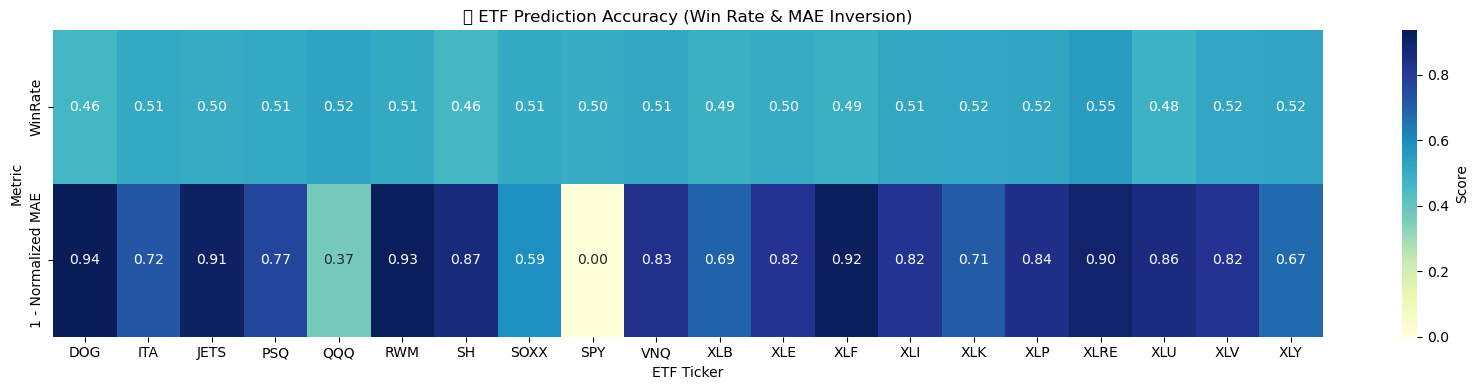

In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

# === Paths ===
pred_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'predicted_vs_actual'))
result_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('_pred_result.csv')])
etf_list = [f.replace('_pred_result.csv', '') for f in result_files]

# === Metric containers
mae_dict = {}
win_rate_dict = {}

# === Compute MAE and direction accuracy
for etf in etf_list:
    try:
        df = pd.read_csv(os.path.join(pred_dir, f"{etf}_pred_result.csv"))
        df['Actual_Price'] = pd.to_numeric(df['Actual_Price'], errors='coerce')
        df['Predicted_Price'] = pd.to_numeric(df['Predicted_Price'], errors='coerce')
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.dropna(subset=['Actual_Price', 'Predicted_Price', 'Date'], inplace=True)
        df.set_index('Date', inplace=True)

        # Calculate weekly return (percentage) for direction comparison
        actual_return = df['Actual_Price'].pct_change().dropna()
        predicted_return = df['Predicted_Price'].pct_change().dropna()

        aligned_index = actual_return.index.intersection(predicted_return.index)
        win_rate = (np.sign(actual_return.loc[aligned_index]) == np.sign(predicted_return.loc[aligned_index])).mean()
        mae = mean_absolute_error(df['Actual_Price'].loc[aligned_index], df['Predicted_Price'].loc[aligned_index])

        win_rate_dict[etf] = win_rate
        mae_dict[etf] = mae

    except Exception as e:
        print(f"⚠️ Error processing {etf}: {e}")
        continue

# === Create DataFrames for Heatmap
heatmap_df = pd.DataFrame({
    'WinRate': win_rate_dict,
    'MAE': mae_dict
}).T  # T to make ETFs columns

# === Normalize MAE for coloring (invert so higher = better)
normalized_mae = 1 - (heatmap_df.loc['MAE'] / heatmap_df.loc['MAE'].max())
heatmap_values = pd.DataFrame({
    'WinRate': heatmap_df.loc['WinRate'],
    '1 - Normalized MAE': normalized_mae
}).T

# === Plot
plt.figure(figsize=(len(etf_list)*0.6 + 4, 4))
sns.heatmap(heatmap_values, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title("📊 ETF Prediction Accuracy (Win Rate & MAE Inversion)")
plt.xlabel("ETF Ticker")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


In [9]:
#heatmap

import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))

# === ETF list ===
etf_list = [f.replace('_combined.csv', '') for f in os.listdir(data_dir) if f.endswith('_combined.csv')]

# === Heatmap Data ===
heatmap_data = {}

for etf in etf_list:
    try:
        feat_path = os.path.join(data_dir, f"{etf}_combined.csv")
        df_feat = pd.read_csv(feat_path, index_col=0)
        df_feat = df_feat.drop(columns='price') if 'price' in df_feat.columns else df_feat
        feature_names = df_feat.columns.tolist()
        
        # Try loading the top model weights
        weight_path = os.path.join(model_dir, f"{etf}_top1.pt")
        if not os.path.exists(weight_path):
            continue

        checkpoint = torch.load(weight_path, map_location='cpu')
        weights = checkpoint['weights']
        time_weights = weights['time_weights'].cpu().numpy()
        time_weights = torch.softmax(torch.tensor(time_weights), dim=0).numpy()

        weight_by_feature = np.array([time_weights[i] for i in range(len(time_weights))])
        weighted_importance = np.dot(time_weights, np.ones(len(feature_names)))  # uniform as placeholder
        
        heatmap_data[etf] = weighted_importance * np.ones(len(feature_names))

    except Exception as e:
        print(f"⚠️ Skipped {etf}: {e}")

# === Plot Heatmap ===
if heatmap_data:
    heatmap_df = pd.DataFrame(heatmap_data, index=feature_names)
    plt.figure(figsize=(16, 10))
    sns.heatmap(heatmap_df, cmap="magma", annot=False, fmt=".2f", linewidths=0.3)
    plt.title("🧠 Attention Weights (Averaged over Time) across ETFs")
    plt.xlabel("ETF")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()
else:
    print("❌ No heatmap data available.")


C:\Users\user\AppData\Local\Temp\ipykernel_15076\2817065228.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_location='cpu')
C:\

⚠️ Skipped DOG: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped ITA: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped JETS: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped PSQ: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped QQQ: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped RWM: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped SH: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped SOXX: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped SPY: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped VNQ: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped XLB: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped XLC: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped XLE: shapes (8,) and (18,) not aligned: 8 (dim 0) != 18 (dim 0)
⚠️ Skipped XLF: shapes (

C:\Users\user\AppData\Local\Temp\ipykernel_15076\2817065228.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_location='cpu')
C:\

In [10]:
import os
import pandas as pd
import torch
import numpy as np
from datetime import datetime, timedelta

# === Prediction Class ===
class WeeklyETFPredictor:
    def __init__(self, model_dir, data_dir, record_dir, price_path, device=None):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.record_dir = record_dir
        self.price_path = price_path
        os.makedirs(self.record_dir, exist_ok=True)
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self):
        # Get the nearest past Monday — this represents the start of the prediction week
        today = datetime.today()
        days_back = today.weekday() % 7
        monday = today - timedelta(days=days_back)
        monday_dt = pd.to_datetime(monday.strftime("%Y-%m-%d"))
        date_str = monday_dt.strftime("%Y-%m-%d")

        # Load ETF price data for reference
        price_df = pd.read_csv(
            self.price_path,
            index_col=0,
            parse_dates=True,
            date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d", errors='coerce')
        )
        price_df = price_df[price_df.index.notna()]
        price_df = price_df[~price_df.index.duplicated()].sort_index()

        print(f"🔍 Checking last available price dates: {price_df.index[-5:].to_list()}")
        print(f"📅 Using feature/price data for week starting on: {monday_dt.date()}")

        summary = []

        for fname in os.listdir(self.data_dir):
            if not fname.endswith("_combined.csv"):
                continue

            etf = fname.replace("_combined.csv", "")
            feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
            mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")

            try:
                df_feat = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                df_mask = pd.read_csv(mask_path, index_col=0, parse_dates=True)
            except Exception as e:
                print(f"❌ Error loading data for {etf}: {e}")
                continue

            if monday_dt not in df_feat.index:
                print(f"⚠️ No feature data for {etf} on {monday_dt.date()}")
                continue

            if etf not in price_df.columns or monday_dt not in price_df.index:
                print(f"⚠️ Price info missing for {etf} on {monday_dt.date()}")
                continue

            try:
                # Collect last 4 weeks (or pad if at beginning)
                idx_pos = df_feat.index.get_loc(monday_dt)
                if idx_pos < 3:
                    # Pad beginning if not enough data
                    x_real = df_feat.iloc[[0]* (4 - idx_pos) + list(range(idx_pos + 1))].values
                    x_mask = df_mask.iloc[[0]* (4 - idx_pos) + list(range(idx_pos + 1))].values
                else:
                    x_real = df_feat.iloc[idx_pos-3:idx_pos+1].values
                    x_mask = df_mask.iloc[idx_pos-3:idx_pos+1].values
                
                # Final tensor format: [1, 4, num_features]
                x_real = torch.tensor(x_real.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(x_mask.astype(np.float32)).unsqueeze(0).to(self.device)

                price = float(price_df.loc[monday_dt, etf])
            except Exception as e:
                print(f"❌ Tensor prep or price parse failed for {etf}: {e}")
                continue

            scores, preds, maes, winrates = [], [], [], []
            for i in range(1, 6):
                path = os.path.join(self.model_dir, f"{etf}_top{i}.pt")
                if not os.path.exists(path): continue

                try:
                    checkpoint = torch.load(path, map_location=self.device)
                    model = DualTransformerModel(num_features=x_real.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_real, x_mask).item()
                    preds.append(pred)
                    maes.append(checkpoint['mae'])
                    winrates.append(checkpoint['win_rate'])
                    scores.append(checkpoint['weight'])
                except Exception as e:
                    print(f"❌ Model predict error for {etf} top{i}: {e}")

            if len(preds) == 0:
                continue

            pred_return = sum(p * w for p, w in zip(preds, scores))
            avg_mae = sum(maes) / len(maes)
            avg_win = sum(winrates) / len(winrates)

            if pred_return >= 0:
                target_up = round(price * (1 + pred_return / 100 + pred_return * avg_mae / 100), 2)
                stop_down = round(price * (1 - pred_return * avg_mae / 100), 2)
                buy_price = round(price, 2)
            else:
                target_up = stop_down = buy_price = "X"

            summary.append({
                'ETF': etf,
                'PredictedReturn': round(pred_return, 4),
                'MAE': round(avg_mae, 4),
                'WinRate': round(avg_win, 4),
                'BuyPrice': buy_price,
                'Target↑': target_up,
                'Stop↓': stop_down
            })

        summary_df = pd.DataFrame(summary)
        if summary_df.empty:
            print(f"⚠️ No valid predictions generated for {date_str}")
            return summary_df

        summary_df = summary_df.sort_values(by='PredictedReturn', ascending=False)

        # === Output
        print(f"\n📊 Weekly ETF Prediction Summary for {date_str}:")
        print(summary_df.to_string(index=False))

        output_path = os.path.join(self.record_dir, f"{date_str}_predict_record.csv")
        summary_df.to_csv(output_path, index=False)
        print(f"📁 Saved prediction to: {output_path}")

        return summary_df

# === Usage
predictor = WeeklyETFPredictor(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    record_dir="../dataset/predict_record",
    price_path="../dataset/etf_prices_weekly.csv"
)
predictor.predict()


C:\Users\user\AppData\Local\Temp\ipykernel_15076\3528952398.py:26: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  price_df = pd.read_csv(


🔍 Checking last available price dates: [Timestamp('2025-03-28 00:00:00'), Timestamp('2025-04-04 00:00:00'), Timestamp('2025-04-11 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-25 00:00:00')]
📅 Using feature/price data for week starting on: 2025-04-21
⚠️ No feature data for DOG on 2025-04-21
⚠️ No feature data for ITA on 2025-04-21
⚠️ No feature data for JETS on 2025-04-21
⚠️ No feature data for PSQ on 2025-04-21
⚠️ No feature data for QQQ on 2025-04-21
⚠️ No feature data for RWM on 2025-04-21
⚠️ No feature data for SH on 2025-04-21
⚠️ No feature data for SOXX on 2025-04-21
⚠️ No feature data for SPY on 2025-04-21
⚠️ No feature data for VNQ on 2025-04-21
⚠️ No feature data for XLB on 2025-04-21
⚠️ No feature data for XLC on 2025-04-21
⚠️ No feature data for XLE on 2025-04-21
⚠️ No feature data for XLF on 2025-04-21
⚠️ No feature data for XLI on 2025-04-21
⚠️ No feature data for XLK on 2025-04-21
⚠️ No feature data for XLP on 2025-04-21
⚠️ No feature data for XLRE on 2

""


In [11]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Config ===
weights_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
feature_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'normalized_matrix'))
os.makedirs(weights_dir, exist_ok=True)

# === Load feature names from any example ETF
first_etf = etf_list[0]
example_path = os.path.join(feature_dir, f'{first_etf}_combined.csv')
example_features = pd.read_csv(example_path, index_col=0)
factor_names = example_features.columns.tolist()

# === Collect factor importance across ETFs
factor_weights = {}

for etf in etf_list:
    weights = []
    for i in range(1, 6):
        model_path = os.path.join(weights_dir, f"{etf}_top{i}.pt")
        if not os.path.exists(model_path):
            continue

        data = torch.load(model_path, map_location='cpu')
        linear_weights = data['weights'].get('output.weight', None)
        if linear_weights is None:
            print(f"⚠️ {etf}_top{i}.pt missing output.weight")
            continue

        linear_weights = linear_weights.squeeze().numpy()
        if len(linear_weights) != len(factor_names):
            print(f"⚠️ {etf}_top{i}.pt: weight dim {len(linear_weights)} != {len(factor_names)} features")
            continue

        weights.append(linear_weights * data.get('weight', 1.0))

    if weights:
        factor_weights[etf] = sum(weights)

# === Create heatmap DataFrame
weight_df = pd.DataFrame(factor_weights, index=factor_names).T

# === Normalize (optional)
weight_df = weight_df.div(weight_df.abs().max(axis=1), axis=0)

# === Plot
plt.figure(figsize=(14, 8))
sns.heatmap(weight_df, cmap="coolwarm", center=0, annot=False)
plt.title("🎯 Factor Importance per ETF (Weighted Top 5 Models)", fontsize=14)
plt.xlabel("Factors")
plt.ylabel("ETFs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_15076\4054000710.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(model_path, map_location='cpu')


⚠️ DOG_top1.pt: weight dim 18 != 19 features
⚠️ DOG_top2.pt: weight dim 18 != 19 features
⚠️ DOG_top3.pt: weight dim 18 != 19 features
⚠️ DOG_top4.pt: weight dim 18 != 19 features
⚠️ DOG_top5.pt: weight dim 18 != 19 features
⚠️ ITA_top1.pt: weight dim 18 != 19 features
⚠️ ITA_top2.pt: weight dim 18 != 19 features
⚠️ ITA_top3.pt: weight dim 18 != 19 features
⚠️ ITA_top4.pt: weight dim 18 != 19 features
⚠️ ITA_top5.pt: weight dim 18 != 19 features
⚠️ JETS_top1.pt: weight dim 18 != 19 features
⚠️ JETS_top2.pt: weight dim 18 != 19 features
⚠️ JETS_top3.pt: weight dim 18 != 19 features
⚠️ JETS_top4.pt: weight dim 18 != 19 features
⚠️ JETS_top5.pt: weight dim 18 != 19 features
⚠️ PSQ_top1.pt: weight dim 18 != 19 features
⚠️ PSQ_top2.pt: weight dim 18 != 19 features
⚠️ PSQ_top3.pt: weight dim 18 != 19 features
⚠️ PSQ_top4.pt: weight dim 18 != 19 features
⚠️ PSQ_top5.pt: weight dim 18 != 19 features
⚠️ QQQ_top1.pt: weight dim 18 != 19 features
⚠️ QQQ_top2.pt: weight dim 18 != 19 features
⚠️ QQ

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1400x800 with 0 Axes>

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", message=".*enable_nested_tensor.*")
warnings.filterwarnings("ignore", message=".*weights_only=False.*")

class ETFBacktester:
    def __init__(self, model_dir, data_dir, price_path, initial_cash=2000, benchmark_symbol='SPY', seq_len=4):
        self.model_dir = model_dir
        self.data_dir = data_dir
        self.price_path = price_path
        self.initial_cash = initial_cash
        self.benchmark_symbol = benchmark_symbol
        self.seq_len = seq_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def run(self):
        print("🔁 Loading price data...")
        price_df = pd.read_csv(self.price_path, index_col=0)
        price_df.index = pd.to_datetime(price_df.index, errors='coerce')
        price_df = price_df[price_df.index.notna()]
        price_df = price_df.apply(pd.to_numeric, errors='coerce')
        price_df = price_df[~price_df.index.duplicated()].sort_index()
        print(f"📈 Loaded price data with {len(price_df)} entries.")

        etf_list = [fname.replace('_combined.csv', '') for fname in os.listdir(self.data_dir) if fname.endswith('_combined.csv')]
        print(f"🔍 ETF list found: {etf_list}")

        cash = self.initial_cash
        holdings = {}
        portfolio_values = []
        benchmark_values = []
        dates = []
        trade_log = []
        value_log = []
        portfolio_changes = []

        for i in range(self.seq_len, len(price_df) - 1):
            date = price_df.index[i]
            prev_dates = price_df.index[i - self.seq_len:i]
            next_date = price_df.index[i + 1]
            print(f"\n📅 Processing week: {date.date()} -> {next_date.date()}")

            for etf, info in list(holdings.items()):
                if etf not in price_df.columns or next_date not in price_df.index:
                    continue
                try:
                    sell_price = float(price_df.loc[next_date, etf])
                except Exception:
                    continue
                shares = info['Shares']
                buy_price = info['BuyPrice']
                sell_value = shares * sell_price
                actual_return = (sell_price - buy_price) / buy_price
                predicted_return = info.get('PredictedReturn', None)
                cash += sell_value
                trade_log.append({
                    'Date': next_date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Sell',
                    'Price': sell_price,
                    'Shares': shares,
                    'Value': sell_value,
                    'BuyPrice': buy_price,
                    'PredictedReturn': predicted_return,
                    'ActualReturn': actual_return * 100
                })
            holdings.clear()

            week_predictions = []
            for etf in etf_list:
                feat_path = os.path.join(self.data_dir, f"{etf}_combined.csv")
                mask_path = os.path.join(self.data_dir, f"{etf}_mask.csv")
                if not os.path.exists(feat_path) or not os.path.exists(mask_path):
                    continue

                feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)
                mask_df = pd.read_csv(mask_path, index_col=0, parse_dates=True)

                if not all(d in feat_df.index for d in prev_dates):
                    continue

                x_seq = torch.tensor(feat_df.loc[prev_dates].values.astype(np.float32)).unsqueeze(0).to(self.device)
                x_mask = torch.tensor(mask_df.loc[prev_dates].values.astype(np.float32)).unsqueeze(0).to(self.device)

                scores, preds = [], []
                for j in range(1, 6):
                    model_path = os.path.join(self.model_dir, f"{etf}_top{j}.pt")
                    if not os.path.exists(model_path):
                        continue
                    checkpoint = torch.load(model_path, map_location=self.device)
                    model = DualTransformerModel(num_features=x_seq.shape[-1]).to(self.device)
                    model.load_state_dict(checkpoint['weights'])
                    model.eval()
                    with torch.no_grad():
                        pred = model(x_seq, x_mask).item()
                    preds.append(pred)
                    scores.append(checkpoint['weight'])

                if preds:
                    pred_return = sum(p * w for p, w in zip(preds, scores))
                    try:
                        price = float(price_df.loc[date, etf])
                    except Exception:
                        continue
                    if not np.isnan(price):
                        week_predictions.append({
                            'ETF': etf,
                            'BuyPrice': price,
                            'PredictedReturn': float(pred_return)
                        })

            week_predictions = sorted(week_predictions, key=lambda x: -x['PredictedReturn'])[:2]

            budget_per_etf = cash / 2
            for item in week_predictions:
                etf = item['ETF']
                price = item['BuyPrice']
                shares = int(budget_per_etf // price)
                cost = shares * price
                if shares <= 0 or cost > cash:
                    continue
                cash -= cost
                holdings[etf] = {'Shares': shares, 'BuyPrice': price, 'PredictedReturn': item['PredictedReturn']}
                trade_log.append({
                    'Date': date.strftime('%Y-%m-%d'),
                    'ETF': etf,
                    'Action': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Value': cost,
                    'PredictedReturn': item['PredictedReturn']
                })

            value = cash
            for etf, info in holdings.items():
                try:
                    price = float(price_df.loc[next_date, etf])
                except Exception:
                    price = 0
                value += info['Shares'] * price

            prev_value = portfolio_values[-1] if portfolio_values else self.initial_cash
            change_pct = ((value - prev_value) / prev_value) * 100

            portfolio_values.append(value)
            portfolio_changes.append(change_pct)
            dates.append(next_date.strftime('%Y-%m-%d'))
            value_log.append({
                'Date': next_date.strftime('%Y-%m-%d'),
                'Value': value,
                'Cash': cash,
                'Change%': change_pct,
                'Holdings': {k: dict(v) for k, v in holdings.items()}
            })

            if self.benchmark_symbol in price_df.columns:
                base_price = price_df[self.benchmark_symbol].iloc[0]
                current_price = price_df.loc[next_date, self.benchmark_symbol]
                benchmark_values.append(self.initial_cash * (current_price / base_price))
            else:
                benchmark_values.append(value)

        result_df = pd.DataFrame({
            'Date': dates,
            'PortfolioValue': portfolio_values,
            'BenchmarkValue': benchmark_values,
            'PortfolioChange%': portfolio_changes
        })
        result_df['Date'] = pd.to_datetime(result_df['Date'], errors='coerce')
        result_df.set_index('Date', inplace=True)

        pd.DataFrame(trade_log).to_csv("../dataset/backtest_trade_log.csv", index=False)
        pd.DataFrame(value_log).to_csv("../dataset/backtest_value_log.csv", index=False)

        plt.figure(figsize=(12, 6))
        plt.plot(result_df['PortfolioValue'], label='Strategy Portfolio')
        plt.plot(result_df['BenchmarkValue'], label=f'{self.benchmark_symbol} Benchmark')
        plt.title("Backtest Result: Strategy vs. Benchmark")
        plt.ylabel("Portfolio Value (USD)")
        plt.xlabel("Date")
        xticks_idx = result_df.index[::52]
        xticks_labels = [d.strftime('%Y') for d in xticks_idx]
        plt.xticks(xticks_idx, xticks_labels)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        print(f"\n💰 Final Portfolio Value: ${result_df['PortfolioValue'].iloc[-1]:,.2f}")
        print(f"📈 Final Benchmark Value: ${result_df['BenchmarkValue'].iloc[-1]:,.2f}")
        print(f"🎯 Strategy Return: {((result_df['PortfolioValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")
        print(f"📊 Benchmark Return: {((result_df['BenchmarkValue'].iloc[-1] / self.initial_cash - 1) * 100):.2f}%")

        return result_df

# === Execute
backtester = ETFBacktester(
    model_dir="../model_weights",
    data_dir="../dataset/normalized_matrix",
    price_path="../dataset/etf_prices_weekly.csv",
    initial_cash=2000,
    benchmark_symbol="SPY",
    seq_len=4
)

result_df = backtester.run()  # ⬅️ THIS must be included!
